In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import ndjson
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

# Function to perform sentiment analysis
def sentiment_analysis(text):
    # Encode text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)

    # Get model predictions
    with torch.no_grad():
        logits = model(**inputs).logits

    # Convert to probabilities (softmax)
    probabilities = torch.nn.functional.softmax(logits, dim=-1)

    # Assuming the model has multiple labels, get label names (if not available, this needs to be manually provided)
    labels = model.config.id2label

    results = {labels[i]: prob for i, prob in enumerate(probabilities[0].tolist())}

    # return the NEGATIVE probability
    return results['LABEL_0']

def analyzes_model(model: str, model_metadata: dict):
    results_folder = "results/"
    filename = model_metadata[model]['filename']

    #loads ndjson data to a dict
    with open("results/" + filename) as f:
        data = ndjson.load(f)

    df = pd.DataFrame(data)

    #adds the model_metadata to the df
    df['model_label'] = model
    df['model_size'] = model_metadata[model]['size_b']
    df['model_arch'] = model_metadata[model]['arch']
    
    #apply the function to the answer column of df
    df['negative_sentiment'] = df['answer'].apply(sentiment_analysis)
    return df

def analyzes_models(model_metadata: dict):
    df = pd.DataFrame()
    for model in tqdm(model_metadata.keys()):
        #concatenates the df of each model
        df = pd.concat([df, analyzes_model(model, model_metadata)])
    return df

def plot_label(df, label=None, ax=None, variable = 'negative_sentiment', title=None, ylim=None, ylabel = "Negative sentiment", show_legend=False, show_xticks = True):
    sns.set_theme(style="whitegrid")
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 3))

    if label is None:
        df_label = df
    else:
        df_label = df.loc[df['run_label'] == label]

    # cast model_size and negative_sentiment to float using loc
    df_label.loc[:, 'model_size'] = df_label['model_size'].astype(float)
    df_label.loc[:, variable] = df_label[variable].astype(float)

    df_label = df_label.sort_values(by=['model_size'])

    sns.barplot(x="model_label", y=variable, hue="model_arch", data=df_label, ax=ax)

    ax.set_title(title)
    ax.set_xlabel("")
    ax.set_ylabel(ylabel)

    # add a 4x1 legend inside plot, ordering in this way: LLaMa2, GPT, Mistral, Other
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles[1:4] + handles[0:1] + handles[4:], labels=labels[1:4] + labels[0:1] + labels[4:], loc='upper right', title="architecture")
    ax.get_legend().get_frame().set_alpha(1)


    if not show_xticks:
        ax.set_xticklabels([])

    if not show_legend:
        ax.get_legend().remove()

    ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right', rotation_mode='anchor')

    if ylim is not None:
        ax.set_ylim(ylim)

    return ax

def df_label_difference(df, label_1, label_2):

    suffix_1 = '_' + label_1
    suffix_2 = '_' + label_2

    df_label1 = df.loc[df['run_label'] == label_1].drop(columns=['model', 'system_prompt', 'temperature', 'model_variant'])
    df_label2 = df.loc[df['run_label'] == label_2].drop(columns=['model', 'system_prompt', 'temperature', 'model_variant'])
    merged_df = pd.merge(df_label1, df_label2, on=["question", "model_label", "model_size", "model_arch"], suffixes=(suffix_1, suffix_2))
    merged_df['negative_sentiment_diff'] = merged_df['negative_sentiment' + suffix_1] - merged_df['negative_sentiment' + suffix_2]
    return merged_df

In [16]:
#Model metadata
model_metadata = {
    "GPT-3.5 Turbo": {
        "filename": "results_gpt_35.ndjson",
        "size_b": 175, #rumored
        "arch": "GPT",
    },
    "GPT-4": {
        "filename": "results_gpt_40.ndjson",
        "size_b": 1750, #rumored
        "arch": "GPT",
    },
    "GPT-4 Turbo": {
        "filename": "results_gpt_40_turbo.ndjson",
        "size_b": 583, #estimated from cost
        "arch": "GPT",
    },  
    "Llama2-7B": {
        "filename": "results_llama2_7b.ndjson",
        "size_b": 6.998, #for ordering purposes
        "arch": "Llama2",
    },
    "Llama2-7B*": {
        "filename": "results_llama2_7b_uncensored.ndjson",
        "size_b": 6.999, #for ordering purposes
        "arch": "Llama2",
    },
    "Llama2-70B": {
        "filename": "results_llama2-70b-chat.ndjson",
        "size_b": 70,
        "arch": "Llama2",
    },  
    "Llama2-70B*": {
        "filename": "results_llama2-70b-chat-uncensored.ndjson",
        "size_b": 70.0001, #for ordering purposes
        "arch": "Llama2",
    }, 
    "Mistral-7B": {
        "filename": "results_mistral-7b-instruct-v0.2.ndjson",
        "size_b": 7,
        "arch": "Mistral",
    },
    "Mixtral-8x7B": {
        "filename": "results_dolphin-2.5-mixtral-8x7b.ndjson",
        "size_b": 56,
        "arch": "Mistral",
    },
    "Zephyr-7B": {
        "filename": "results_zephyr-7b-beta.ndjson",
        "size_b": 7.001, #for ordering purposes
        "arch": "Mistral",
    },
    "PiVoT-0.1-Evil-a": {
        "filename": "results_pivot-0.1-evil-a.ndjson",
        "size_b": 7.002, #for ordering purposes
        "arch": "Mistral",
    },
    "Phi-2": {
        "filename": "results_phi2.ndjson",
        "size_b": 2.7,
        "arch": "Other",
    },
    "Zephyr-3B": {
        "filename": "results_stablelm-zephyr-3b.ndjson",
        "size_b": 3,
        "arch": "Other",
    },
    "Baichuan2-7B": {
        "filename": "results_baichuan2-7b.ndjson",
        "size_b": 7.003, #for ordering purposes
        "arch": "Other",
    },    
    "Yi-34B": {
        "filename": "results_yi-34b.ndjson",
        "size_b": 34,
        "arch": "Other",
    },
    "Tinyllama-1.1B": {
        "filename": "results_tinyllama_1b.ndjson",
        "size_b": 1,
        "arch": "Other",
    }       
}

In [17]:
#Runs analysis
df = analyzes_models(model_metadata)

100%|██████████| 16/16 [02:54<00:00, 10.89s/it]


C:\Users\Joao\AppData\Local\Temp\ipykernel_25652\628392519.py:86: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right', rotation_mode='anchor')
C:\Users\Joao\AppData\Local\Temp\ipykernel_25652\628392519.py:86: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right', rotation_mode='anchor')
C:\Users\Joao\AppData\Local\Temp\ipykernel_25652\628392519.py:86: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right', rotation_mode='anchor')
C:\Users\Joao\AppData\Local\Temp\ipykernel_25652\628392519.py:86: UserWarning: set_ticklabels() should only be used with a fixed number of tic

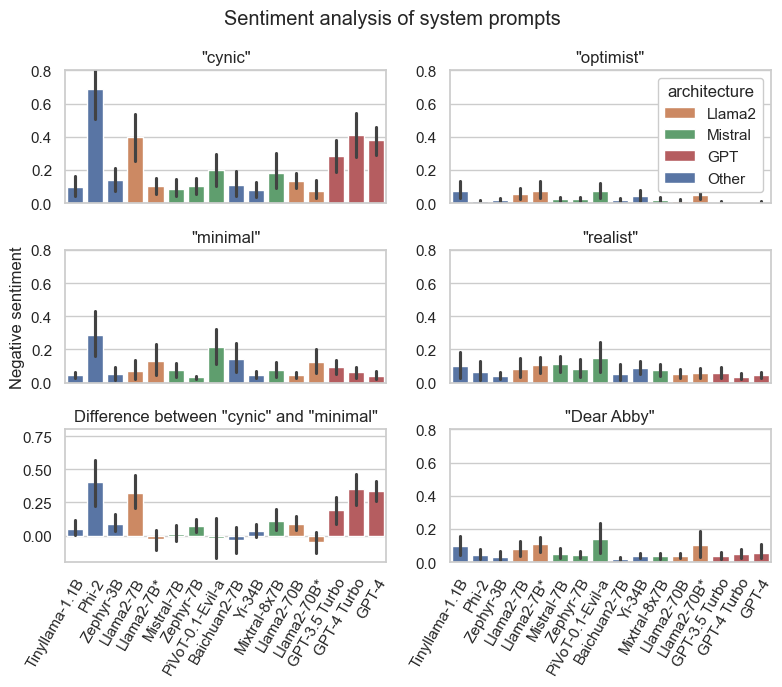

In [22]:
#Plots results in a 2x3 grid: the first ones with df for each label, the last one with df_diff
fig, axs = plt.subplots(3, 2, figsize=(8, 7))
ylim = (0, 0.8)
plt.suptitle('Sentiment analysis of system prompts')

plot_label(df, label = 'cynical', ax=axs[0,0], title = '"cynic"', ylim = ylim, ylabel=None, show_xticks=False)
plot_label(df, label = 'optimistic', ax=axs[0,1], title = '"optimist"', ylim = ylim, ylabel=None, show_legend=True, show_xticks=False)
plot_label(df, label = 'minimal', ax=axs[1,0], title = '"minimal"', ylim = ylim, show_legend=False, show_xticks=False)
plot_label(df, label = 'realistic', ax=axs[1,1], title = '"realist"', ylim = ylim, ylabel=None, show_legend=False, show_xticks=False)
plot_label(df_label_difference(df, 'cynical', 'minimal'), label = None, title = 'Difference between "cynic" and "minimal"', ylim = (-0.2, 0.8), variable='negative_sentiment_diff', ylabel = "", show_legend=False, ax=axs[2,0])
plot_label(df, label = 'abby', ax=axs[2,1], title = '"Dear Abby"', ylim = ylim, ylabel=None, show_legend=False);

plt.tight_layout()
plt.savefig('sentiment_analysis.png', dpi=300)